## word2vec 개선 1

##### Embedding 계층 구현

In [1]:
import numpy as np
W = np.arange(21).reshape(7, 3)
print(W)
print(W[2])
print(W[5])

[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]
 [12 13 14]
 [15 16 17]
 [18 19 20]]
[6 7 8]
[15 16 17]


In [2]:
idx = np.array([1, 0, 3, 0])
print(W[idx])

[[ 3  4  5]
 [ 0  1  2]
 [ 9 10 11]
 [ 0  1  2]]


Embedding 클래스

In [3]:
class Embedding:
  def __init__(self, W):
    self.params= [W]
    self.grads = [np.zeros_like(W)]
    self.idx = None

  def forward(self, idx):
    W, = self.params
    self.idx = idx
    out = W[idx]
    return out

  def backward(self, dout):
    dW, = self.grads
    dW[...] = 0
    dW[self.idx] = dout   # 실은 나쁜 예
    return None

In [4]:
# backward 올바른 예

class Embedding:
  def __init__(self, W):
    self.params= [W]
    self.grads = [np.zeros_like(W)]
    self.idx = None

  def forward(self, idx):
    W, = self.params
    self.idx = idx
    out = W[idx]
    return out

  def backward(self, dout):
    dW, = self.grads
    dW[...] = 0
    for i, word_in in enumerate(self.idx):
      dW[word_in] += dout[i]

    # 혹은
    # np.add.at(dW, self.idx, dout)

    return None

## word2vec 개선 2

#### 다중분류에서 이진 분류로(구현)

In [5]:
class EmbeddingDot:
  def __init__(self, W):
    self.embed = Embedding(W)
    self.params = self.embed.params
    self.grads = self.embed.grads
    self.cache = None

  def forward(self, h, idx):
    target_W = self.embed.forward(idx)
    out = np.sum(target_W * h, axis = 1)

    self.cache = (h, target_W)
    return out

  def backward(self, dout):
    h, target_W = self.cache
    dout = dout.reshape(dout.shape[0], 1)

    dtarget_W = dout * h
    self.embed.backward(dtarget_W)
    dh = dout * target_W
    return dh

#### 네거티브 샘플링 구현

In [6]:
%cd /content/drive/MyDrive/colab/deep_learning_basic/밑바닥부터_시작하는_딥러닝2

/content/drive/MyDrive/colab/deep_learning_basic/밑바닥부터_시작하는_딥러닝2


In [7]:
from ch04.negative_sampling_layer import UnigramSampler, EmbeddingDot
from common.layers import SigmoidWithLoss
class NegativeSamplingLoss:
  def __init__(self, W, corpus, power = 0.75, sample_size = 5):
    self.sample_size = sample_size
    self.sampler = UnigramSampler(corpus, power, sample_size)
    self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)]
    self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]
    self.params, self.grads = [], []
    for layer in self.embed_dot_layers:
      self.params += layer.params
      self.grads += layer. grads

  def forward(self, h, target):
    batch_size = target.shape[0]
    negative_sample = self.sampler.get_negative_sample(target)

    # 긍정적 예 순전파
    score = self.embed_dot_layers[0].forward(h, target)
    correct_label = np.ones(batch_size, dtype = np.int32)
    loss = self.loss_layers[0].forward(score, correct_label)

    # 부정적 예 순전파
    negative_label = np.zeros(batch_size, dtype = np.int32)
    for i in range(self.sample_size):
      negative_target = negative_sample[:, i]
      score = self.embed_dot_layers[1 + i].forward(h, negative_target)
      loss += self.loss_layers[1 + i].forward(score, negative_label)

    return loss

  def backward(self, dout = 1):
    dh = 0
    for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
      dscore = l0.backward(dout)
      dh += l1.backward(dscore)

    return dh

## 개선판 word2vec 학습

#### CBOW 모델 구현

In [8]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import Embedding
from ch04.negative_sampling_layer import NegativeSamplingLoss

class CBOW:
  def __init__(self, vocab_size, hidden_size, window_size, corpus):
    V, H = vocab_size, hidden_size

    # 가중치 초기화
    W_in = 0.01 * np.random.randn(V, H).astype('f')
    W_out = 0.01 * np.random.randn(V, H).astype('f')

    # 계층 생성
    self.in_layers = []
    for i in range(2 * window_size):
      layer = Embedding(W_in)     # Embdeeing 계층 사용
      self.in_layers.append(layer)
    self.ns_loss = NegativeSamplingLoss(W_out, corpus, power = 0.75, sample_size = 5)

    # 모든 가중치와 기울기를 배열에 모은다.
    layers = self.in_layers + [self.ns_loss]
    self.params, self.grads = [], []
    for layer in layers:
      self.params += layer.params
      self.grads += layer.grads

    # 인스턴스 변수에 단어의 분산 표현을 저장한다.
    self.word_vecs = W_in

  def forward(self, contexts, target):
    h = 0
    for i, layer in enumerate(self.in_layers):
      h += layer.forward(contexts[:, i])
    h *= 1 / len(self.in_layers)
    loss = self.ns_loss.forward(h, target)
    return loss

  def backward(self, dout = 1):
    dout = self.ns_loss.backward(dout)
    dout *= 1 / len(self.in_layers)
    for layer in self.in_layers:
      layer.backward(dout)
    return None

#### CBOW 모델 학습 코드

| 에폭 1 |  반복 1 / 9295 | 시간 0[s] | 손실 4.16
| 에폭 1 |  반복 21 / 9295 | 시간 1[s] | 손실 4.16
| 에폭 1 |  반복 41 / 9295 | 시간 2[s] | 손실 4.15
| 에폭 1 |  반복 61 / 9295 | 시간 4[s] | 손실 4.13
| 에폭 1 |  반복 81 / 9295 | 시간 5[s] | 손실 4.05
| 에폭 1 |  반복 101 / 9295 | 시간 6[s] | 손실 3.93
| 에폭 1 |  반복 121 / 9295 | 시간 7[s] | 손실 3.79
| 에폭 1 |  반복 141 / 9295 | 시간 9[s] | 손실 3.64
| 에폭 1 |  반복 161 / 9295 | 시간 10[s] | 손실 3.48
| 에폭 1 |  반복 181 / 9295 | 시간 11[s] | 손실 3.36
| 에폭 1 |  반복 201 / 9295 | 시간 13[s] | 손실 3.25
| 에폭 1 |  반복 221 / 9295 | 시간 14[s] | 손실 3.17
| 에폭 1 |  반복 241 / 9295 | 시간 15[s] | 손실 3.09
| 에폭 1 |  반복 261 / 9295 | 시간 16[s] | 손실 3.02
| 에폭 1 |  반복 281 / 9295 | 시간 18[s] | 손실 2.96
| 에폭 1 |  반복 301 / 9295 | 시간 19[s] | 손실 2.92
| 에폭 1 |  반복 321 / 9295 | 시간 20[s] | 손실 2.87
| 에폭 1 |  반복 341 / 9295 | 시간 22[s] | 손실 2.85
| 에폭 1 |  반복 361 / 9295 | 시간 23[s] | 손실 2.81
| 에폭 1 |  반복 381 / 9295 | 시간 24[s] | 손실 2.79
| 에폭 1 |  반복 401 / 9295 | 시간 25[s] | 손실 2.78
| 에폭 1 |  반복 421 / 9295 | 시간 27[s] | 손실 2.75
| 에폭 1 |  반복 441 / 9295 

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49552 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49892 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_te

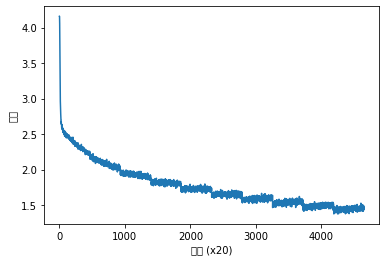

In [9]:
import sys
sys.path.append('..')
import numpy as np
from common import config
import pickle
from common.trainer import Trainer
from common.optimizer import Adam
from ch04.cbow import CBOW
from common.util import create_contexts_target, to_cpu, to_gpu
from dataset import ptb

# 하이퍼파리미터 설정
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

# 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)
if config.GPU:
  contexts, target = to_gpu(contexts), to_gpu(target)

# 모델 등 생성
model = CBOW(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# 학습 시작
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

# 나중에 사용할 수 있도록 필요한 데이터 저장
word_vecs = model.word_vecs
if config.GPU:
  word_vecs = to_cpu(word_vecs)

params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'
with open(pkl_file, 'wb') as f:
  pickle.dump(params, f, -1)

#### CBOW 모델 평가

In [10]:
import sys
sys.path.append('..')
from common.util import most_similar, analogy
import pickle

pkl_file = 'cbow_params.pkl'

with open(pkl_file, 'rb') as f:
  params = pickle.load(f)
  word_vecs = params['word_vecs']
  word_to_id = params['word_to_id']
  id_to_word = params['id_to_word']

# 가장 비슷한(most similar) 단어 뽑기
querys = ['you', 'your', 'car', 'toyota']
for query in querys:
  most_similar(query, word_to_id, id_to_word, word_vecs, top = 5)

# 유추(analogy) 작업
print('-'*50)
analogy('king', 'man', 'queen',  word_to_id, id_to_word, word_vecs)
analogy('take', 'took', 'go',  word_to_id, id_to_word, word_vecs)
analogy('car', 'cars', 'child',  word_to_id, id_to_word, word_vecs)
analogy('good', 'better', 'bad',  word_to_id, id_to_word, word_vecs)


[query] you
 we: 0.77294921875
 i: 0.66943359375
 they: 0.63818359375
 me: 0.587890625
 weird: 0.576171875

[query] your
 my: 0.654296875
 you: 0.5751953125
 wsj: 0.51025390625
 her: 0.49853515625
 our: 0.498291015625

[query] car
 luxury: 0.626953125
 auto: 0.57958984375
 truck: 0.578125
 merkur: 0.56787109375
 window: 0.56396484375

[query] toyota
 honda: 0.677734375
 nissan: 0.66796875
 chevrolet: 0.61083984375
 seita: 0.59423828125
 supermarkets: 0.59326171875
--------------------------------------------------

[analogy] king:man = queen:?
 woman: 5.3203125
 a.m: 5.08984375
 cubans: 4.921875
 answers: 4.828125
 father: 4.73828125

[analogy] take:took = go:?
 eurodollars: 5.49609375
 're: 4.49609375
 went: 4.29296875
 a.m: 4.26953125
 came: 4.15625

[analogy] car:cars = child:?
 a.m: 7.015625
 rape: 5.59375
 children: 5.421875
 incest: 4.9609375
 daffynition: 4.90234375

[analogy] good:better = bad:?
 less: 5.59375
 more: 5.5546875
 rather: 5.515625
 greater: 4.55859375
 faster: 3.

## 정리

- Embedding 계층은 단어의 분산 표현을 담고 있으며, 순전파 시 지정한 단어 ID의 벡터를 추출한다.
- word2vec은 어휘 수의 증가에 비례하여 계산량도 증가하므로, 근사치로 계산하는 빠른 기법을 사용하면 좋다.
- 네거티브 샘플링은 부정적 예를 몇 개 샘플링하는 기법으로, 이를 이용하면 다중 분류를 이진 분류처럼 취습할 수 있다.
- word2vec으로 얻은 단어의 분산 표현에는 단어의 의미가 녹아들어 있으며, 비슷한 맥락에서 사용되는 단어는 단어 벡터 공간에서 가까이 위치한다.
- word2vec의 단어의 분산 표현을 이용하면 유추 문제를 벡터의 덧셈과 뺄셈으로 풀 수 있게 된다.
- word2vec은 전이 학습 측면에서 특히 중요하며, 그 단어의 분산 표현은 다양한 자연어 처리 작업에 이용할 수 있다.